In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurements = Base.classes.measurement
stations = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)).\
        filter(measurements.date >= start_date).filter(measurements.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set
year_temps = calc_temps('2015-02-28', '2016-02-29')
year_temps

[(56.0, 74.16694701429773, 86.0)]

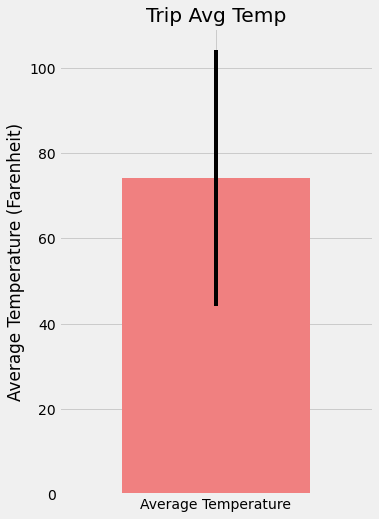

In [11]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
x_axis = "Average Temperature"                          
y_axis = year_temps[0][1]
plt.figure(figsize=(5,8))
plt.bar(x_axis,y_axis, color='lightcoral',width=.6,
        yerr=(year_temps[0][0]-year_temps[0][2]))
plt.xlim(-0.5,0.5)
plt.ylabel("Average Temperature (Farenheit)")
plt.title("Trip Avg Temp")
plt.savefig('outputs/avgtemp.png')
plt.show()

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
starttrip_eq = '2016-08-01'
endtrip_eq = '2016-08-07'

# Run query and sort in descending order by precipitation amount and list the station, 
# name, latitude, longitude, and elevation
rainquery = session.query(stations.id, stations.station, stations.latitude, stations.longitude, 
                     stations.elevation, func.sum(measurements.prcp)).\
    filter(measurements.date >= starttrip_eq, measurements.date <= endtrip_eq).\
    filter(measurements.station == stations.station).\
    group_by(measurements.station).\
order_by(func.sum(measurements.prcp).desc()).statement
rainavg = pd.read_sql_query(rainquery, session.bind)

#Rename and format DataFrame
rainavg = rainavg.rename(columns={'id': 'Station ID',
                        'station': 'Station Name',
                        'latitude': 'Lat',
                        'longitude': 'Lng',
                        'elevation': 'Elevation',
                        'sum_1': 'Total Rainfall (In)'})
rainavg.head()

,Station ID,Station Name,Lat,Lng,Elevation,Total Rainfall (In)
0,7,USC00519281,21.45167,-157.84889,32.9,6.02
1,9,USC00516128,21.33310,-157.80250,152.4,4.65
2,2,USC00513117,21.42340,-157.80150,14.6,3.59
3,6,USC00519523,21.33556,-157.71139,19.5,1.30
4,3,USC00514830,21.52130,-157.83740,7.0,1.03


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(measurements.tobs), func.avg(measurements.tobs), func.max(measurements.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", measurements.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
dts = session.query(measurements.date).\
    filter(measurements.date >= start_date, measurements.date <= end_date).\
    group_by(measurements.date).all() 

# Strip off the year and save a list of strings in the format %m-%d
datesstr = []
for date in dts:
    monthday = pd.to_datetime(date)
    datesstr.append(f'0{monthday.month[0]}-0{monthday.day[0]}')

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
normals = []
for date in datesstr:
    dn = daily_normals(date)
    for d in dn:
        normals.append(d)
normals = np.around(normals,1).tolist()
normals

[[67.0, 75.5, 83.0],
 [68.0, 75.6, 84.0],
 [70.0, 76.6, 85.0],
 [69.0, 76.7, 84.0],
 [69.0, 76.1, 82.0],
 [67.0, 76.2, 83.0],
 [71.0, 77.2, 83.0]]

In [15]:
# Format date range list
rangedt = []
for date in dts:
    monthday = pd.to_datetime(date)
    rangedt.append(f'{monthday.year[0]}-0{monthday.month[0]}-0{monthday.day[0]}')
rangedt

['2017-08-01',
 '2017-08-02',
 '2017-08-03',
 '2017-08-04',
 '2017-08-05',
 '2017-08-06',
 '2017-08-07']

In [16]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normaldf = pd.DataFrame(normals,index = rangedt, columns = ['Min Temp', 'Avg Temp', 'Max Temp'])
normaldf

,Min Temp,Avg Temp,Max Temp
2017-08-01,67.0,75.5,83.0
2017-08-02,68.0,75.6,84.0
2017-08-03,70.0,76.6,85.0
2017-08-04,69.0,76.7,84.0
2017-08-05,69.0,76.1,82.0
2017-08-06,67.0,76.2,83.0
2017-08-07,71.0,77.2,83.0


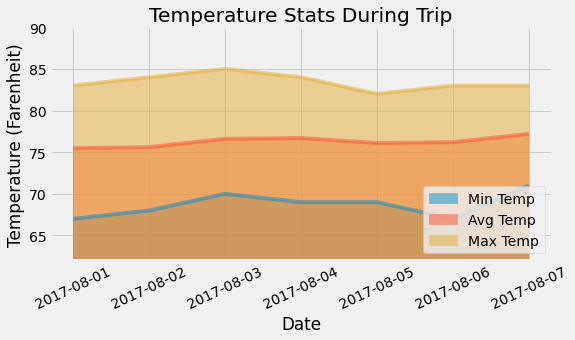

In [17]:
# Plot the daily normals as an area plot with `stacked=False`
normaldf.plot.area(figsize=(8, 4),                                
                       stacked=False,                                  
                       title='Temperature Stats During Trip', 
                       ylim=(min(normaldf['Min Temp'])-5, max(normaldf['Max Temp'])+5),                
                       rot=25,                                         
                       legend=True)
plt.xlabel("Date")
plt.ylabel("Temperature (Farenheit)")
plt.savefig('outputs/areatemps.png')
plt.show()

## Close Session

In [18]:
session.close()